In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import skimage

In [2]:
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
def plt_show(name,img1,img2):
    plt.figure(figsize = (10,10))
    plt.subplot(121);plt.imshow(img1,cmap='gray');plt.title(name)
    plt.subplot(122);plt.imshow(img2,cmap='gray');plt.title('Oringal')
    plt.show()

In [4]:
def plt_show1(name,img1,img2):
    plt.figure(figsize = (10,10))
    plt.subplot(121);plt.imshow(img1);plt.title(name)
    plt.subplot(122);plt.imshow(img2);plt.title('Oringal')
    plt.show()

## Feature points detection

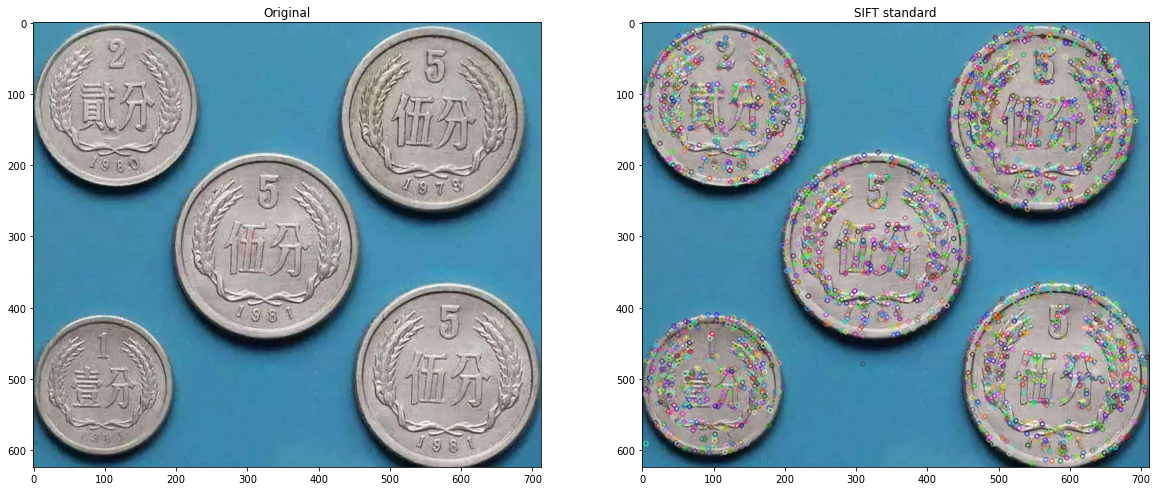

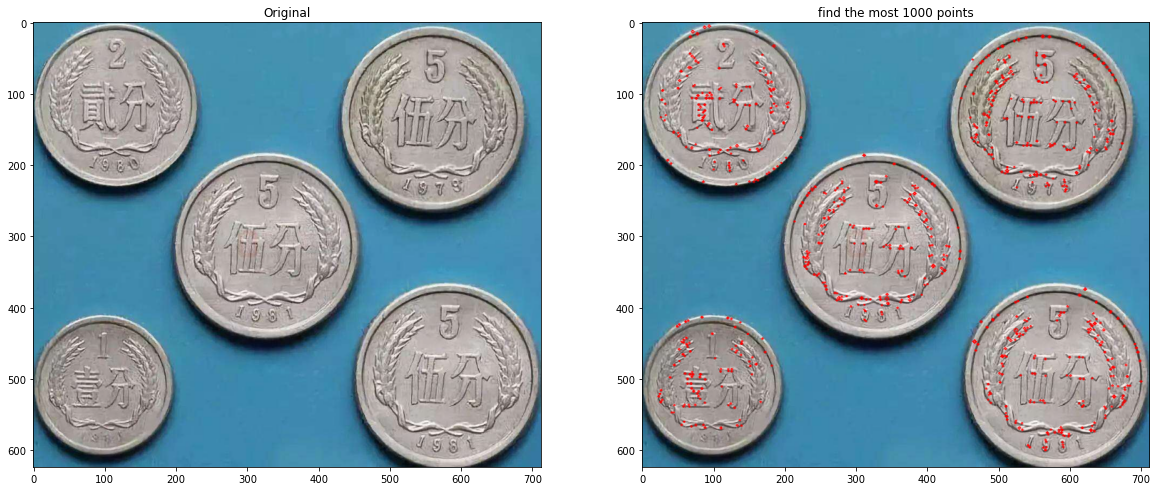

In [45]:
fn = "coins.png"
img = cv2.imread(fn,cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

#SIFT normal
detector = cv2.SIFT_create()
keypoints = detector.detect(gray,None)
res1 = cv2.drawKeypoints(gray,keypoints,outImage = None)

# find the most 1000 points
detector = cv2.SIFT_create(1000)
keypoints = detector.detect(gray,None)
#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS will also show the direction of the feature points
res2 = cv2.drawKeypoints(gray,keypoints,outImage = None, color = (255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize = (20,20))
plt.subplot(121);plt.imshow(gray);plt.title('Original')
plt.subplot(122);plt.imshow(res1);plt.title('SIFT standard')
plt.show()

plt.figure(figsize = (20,20))
plt.subplot(121);plt.imshow(gray);plt.title('Original')
plt.subplot(122);plt.imshow(res2);plt.title('find the most 1000 points')
plt.show()

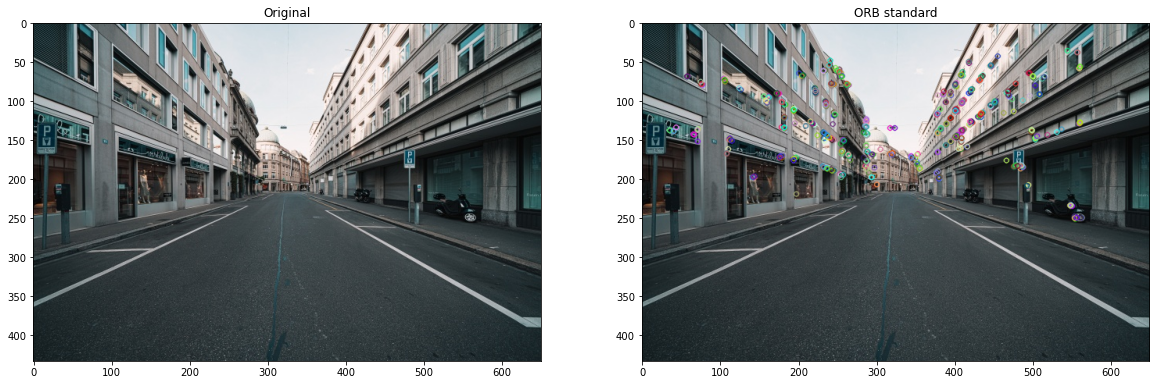

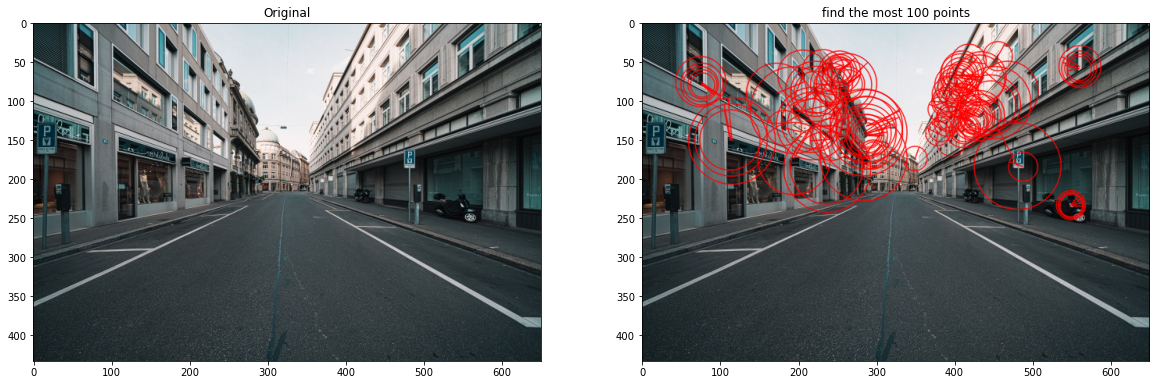

In [41]:
fn = "building."
img = cv2.imread(fn,cv2.IMREAD_COLOR)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# ORB normal
detector = cv2.ORB_create()
keypoints = detector.detect(gray,None)
res1 = cv2.drawKeypoints(img,keypoints,outImage = None)

# find the most 1000 points
detector = cv2.ORB_create(100)
keypoints = detector.detect(gray,None)
res2 = cv2.drawKeypoints(img,keypoints,outImage = None, color = (255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize = (20,20))
plt.subplot(121);plt.imshow(img);plt.title('Original')
plt.subplot(122);plt.imshow(res1);plt.title('ORB standard')
plt.show()

plt.figure(figsize = (20,20))
plt.subplot(121);plt.imshow(img);plt.title('Original')
plt.subplot(122);plt.imshow(res2);plt.title('find the most 100 points')
plt.show()

## Feature point matching

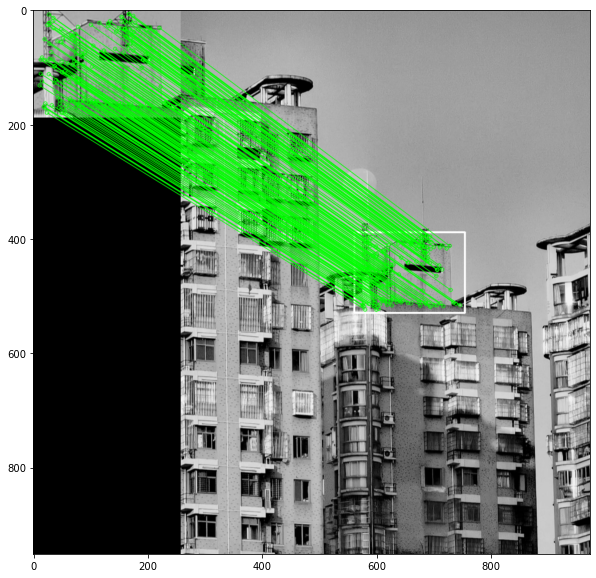

In [39]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv2.imread('building_part.png',0)
img2 = cv2.imread('building.png',0)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,2, cv2.LINE_AA)

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0),singlePointColor = None,matchesMask = matchesMask,flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize=(10,10));plt.imshow(img3, 'gray');plt.show()

## Automatic Image Stitching 

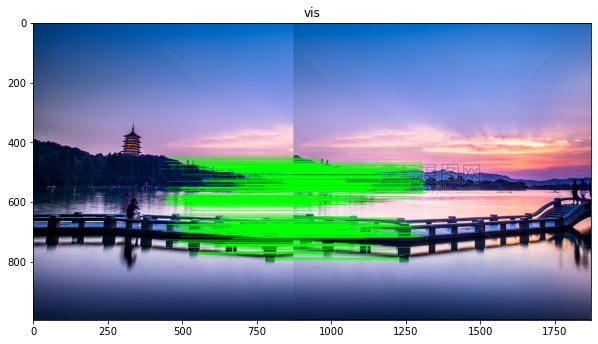

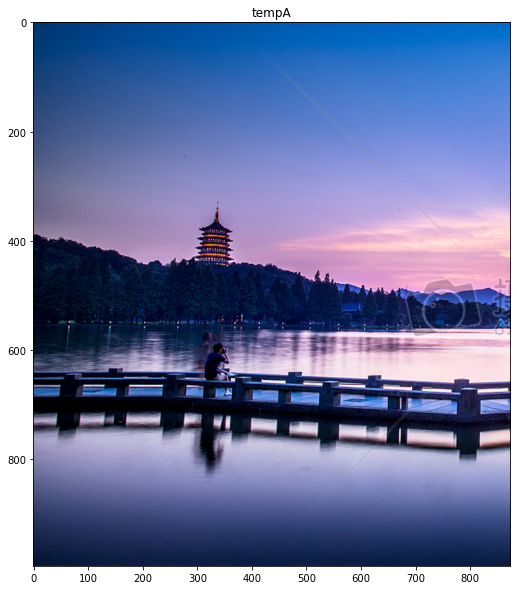

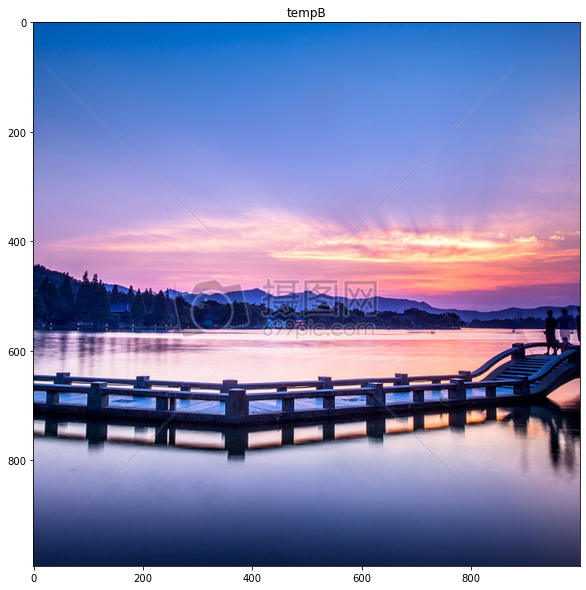

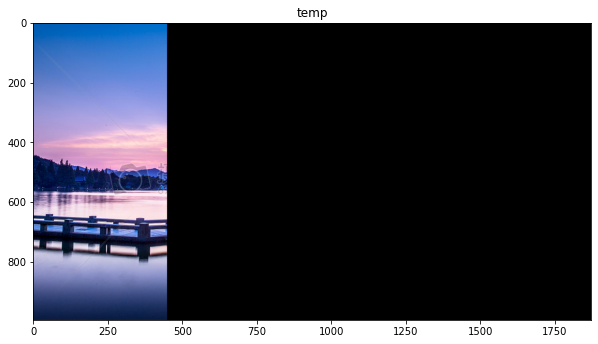

450


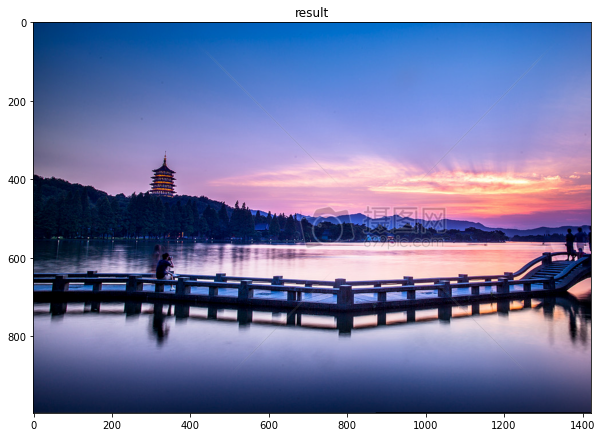

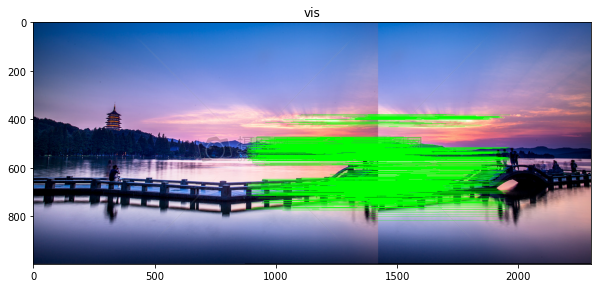

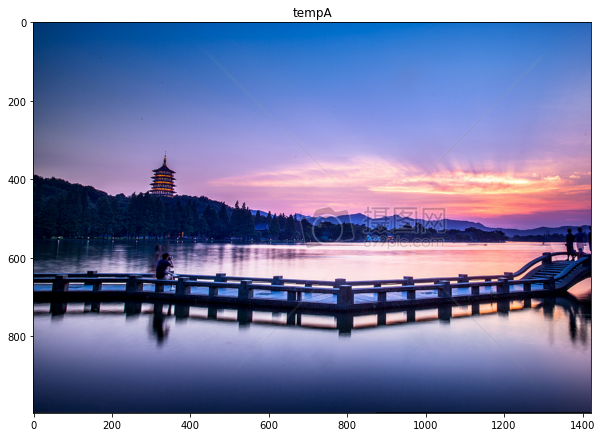

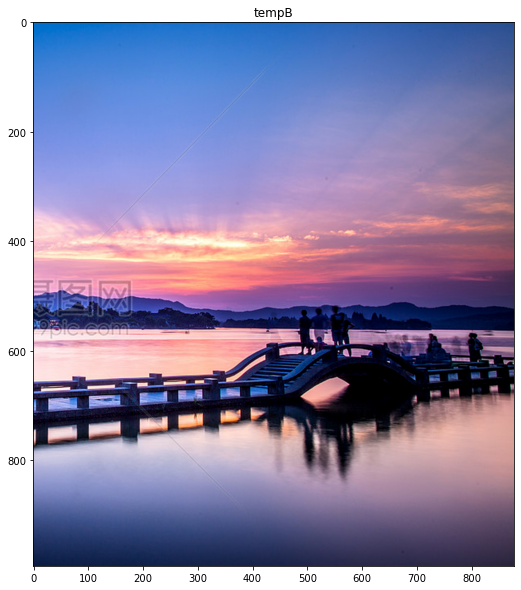

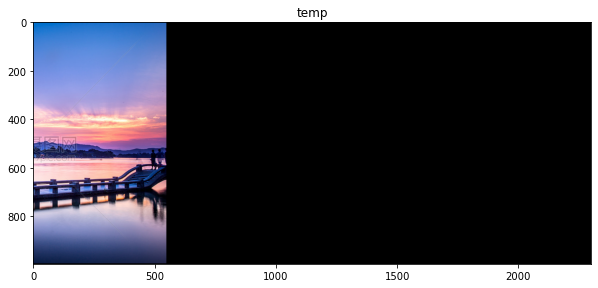

550


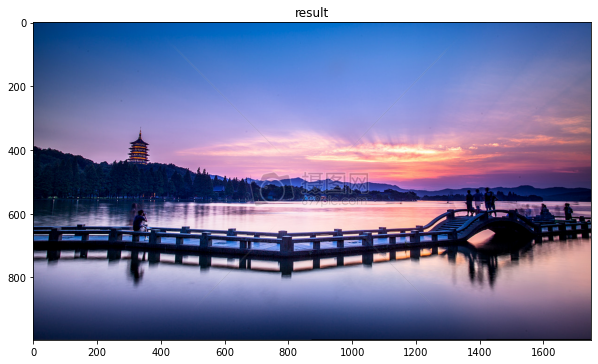

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def cv_show(name, image):
    cv2.imshow(name, image)
    cv2.waitKey()
    cv2.destroyAllWindows()
    return
 
def detectAndDescribe(image):
    # 将彩色图片转换成灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 建立SIFT生成器
    descriptor = cv2.SIFT_create()
    # 检测SIFT特征点，并计算描述子
    (kps, features) = descriptor.detectAndCompute(image, None)
    # 将结果转换成NumPy数组
    kps = np.float32([kp.pt for kp in kps])
    # 返回特征点集，及对应的描述特征
    return (kps, features)

def matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio = 0.75, reprojThresh = 4.0):
    # 建立暴力匹配器
    matcher = cv2.BFMatcher()
    # 使用KNN检测来自A、B图的SIFT特征匹配对，K=2
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []
    for m in rawMatches:
        # 当最近距离跟次近距离的比值小于ratio值时，保留此匹配对
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        # 存储两个点在featuresA, featuresB中的索引值
            matches.append((m[0].trainIdx, m[0].queryIdx))
        # 当筛选后的匹配对大于4时，计算视角变换矩阵
    if len(matches) > 4:
        # 获取匹配对的点坐标
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])
        # 计算视角变换矩阵
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
        # 返回结果
        return (matches, H, status)
    # 如果匹配对小于4时，返回None
    return None

def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # 初始化可视化图片，将A、B图左右连接到一起
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB
    # 联合遍历，画出匹配对
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # 当点对匹配成功时，画到可视化图上
        if s == 1:
            # 画出匹配对
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
#     cv_show("drawImg", vis)
    plt.figure(figsize=(10,10));plt.imshow(vis);plt.title('vis');plt.show()
    # 返回可视化结果
    return vis

def find_conter(image):
    col = image.shape[1]
    for i in range(col,0,-1):
        if list(image[0][i-1]) != [0,0,0]:
            return i
            break
    return 0
            

def stitch(imageA,imageB, ratio=0.75, reprojThresh=4.0,showMatches=False):
    tempA = imageA.copy()
    tempB = imageB.copy()
    
    plt.figure(figsize=(10,10));plt.imshow(tempA);plt.title('tempA');plt.show()
    plt.figure(figsize=(10,10));plt.imshow(tempB);plt.title('tempB');plt.show()
    
    #检测A、B图片的SIFT关键特征点，并计算特征描述子
    (kpsA, featuresA) = detectAndDescribe(tempA)
    (kpsB, featuresB) = detectAndDescribe(tempB)
    # 匹配两张图片的所有特征点，返回匹配结果
    M = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
    # 如果返回结果为空，没有匹配成功的特征点，退出算法,否则，提取匹配结果
    if M is None:
        return None

    # H是3x3视角变换矩阵      
    (matches, H, status) = M
    # 将图片A进行视角变换，result是变换后图片
    result = cv2.warpPerspective(tempA, H, (tempA.shape[1] + tempB.shape[1], tempA.shape[0]))
    plt.figure(figsize=(10,10));plt.imshow(result);plt.title('temp');plt.show()
    
    # 找到交叉图片的大小
    index = find_conter(result)
    print(index)
     
    # 将图片B传入result图片最左端
    # 将两张图片进行合并
    row = min(tempA.shape[0],tempB.shape[0])
    result[0:tempA.shape[0],0:tempA.shape[1]] = tempA
    result[0:row,tempA.shape[1]:tempA.shape[1] + tempB.shape[1] - index] = tempB[0:row,index:tempB.shape[1]]
     
    # 将图像进行调整
    index = find_conter(result)
    res_new = result[:,:index,:]
    plt.figure(figsize=(10,10));plt.imshow(res_new);plt.title('result');plt.show()
    # 返回匹配结果
    return res_new

# 读取图像
imageA = cv2.imread('image1.png')
imageB = cv2.imread('image2.png')
imageC = cv2.imread('image3.png')
imageA = cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB)
imageB = cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB)
imageC = cv2.cvtColor(imageC,cv2.COLOR_BGR2RGB)
# 计算SIFT特征点和特征向量
(kpsA, featuresA) = detectAndDescribe(imageA)
(kpsB, featuresB) = detectAndDescribe(imageB)
# 基于最近邻和随机取样一致性得到一个单应性矩阵
(matches,H,status) = matchKeypoints(kpsA, kpsB, featuresA, featuresB)

# 绘制匹配结果
vis1 = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
# 拼接
res1 = stitch(imageA, imageB)

(kps, features) = detectAndDescribe(res1)
(kpsC, featuresC) = detectAndDescribe(imageC)
(matches,H,status) = matchKeypoints(kps, kpsC, features, featuresC)
vis2 = drawMatches(res1, imageC, kps, kpsC, matches, status)
res2 = stitch(res1, imageC)